In [200]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Stage 2: David

Generate weekly statistics for a single state.

<Axes: >

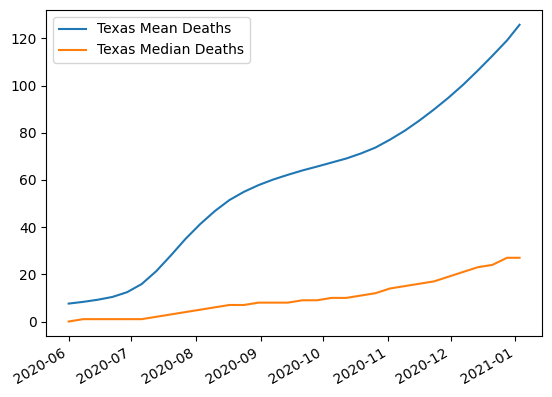

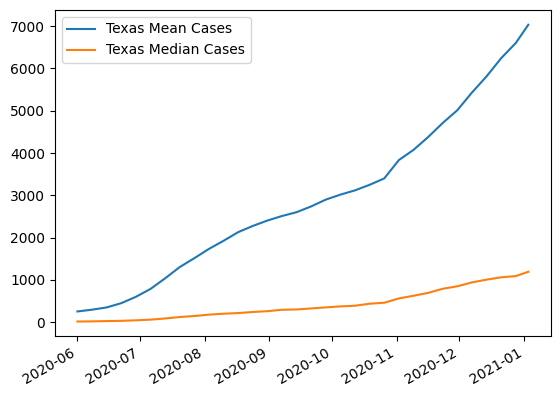

In [201]:
# This is mostly a copy paste of the code Derik and I contributed to the main project.
super_covid = pd.read_csv('./data/super_covid_data.csv')
covid_cases = pd.read_csv('./data/covid_confirmed_usafacts.csv')
covid_deaths = pd.read_csv('./data/covid_deaths_usafacts.csv')
covid_pop = pd.read_csv('./data/covid_county_population_usafacts.csv')

# It will be easier to handle these separately so I'm importing the deaths and cases CSVs again.

# Create a dataframe I actually want to manipulate
cd_date = covid_deaths.drop(covid_deaths.columns[[0, 1, 2, 3]], axis=1, inplace=False)

#Transpose
cd_date = cd_date.transpose()

# Change the index to a date and time so that I can resample it.
cd_date.index = pd.to_datetime(cd_date.index)

#Repeat this process for Cases
cc_date = covid_cases.drop(covid_cases.columns[[0, 1, 2, 3]], axis=1, inplace=False)
cc_date = cc_date.transpose()
cc_date.index = pd.to_datetime(cc_date.index)

start_date = pd.to_datetime('2020-06-01')
end_date = pd.to_datetime('2021-01-03')

cd_date = cd_date.T
cd_date = cd_date[[col for col in cd_date.columns if start_date <= col <= end_date]]

cc_date = cc_date.T
cc_date = cc_date[[col for col in cc_date.columns if start_date <= col <= end_date]]

cd_last_date = cd_date.iloc[:, -1:]
cd_date = cd_date.loc[:, ::7]
cd_date = pd.concat([cd_date, cd_last_date], axis=1)

cc_last_date = cc_date.iloc[:, -1:]
cc_date = cc_date.loc[:, ::7]
cc_date = pd.concat([cc_date, cc_last_date], axis=1)

# Put my Dataframes back together
covid_deaths.drop(columns=covid_deaths.columns[4:], inplace=True)
covid_deaths = pd.concat([covid_deaths, cd_date], axis=1)

covid_cases.drop(columns=covid_cases.columns[4:], inplace=True)
covid_cases = pd.concat([covid_cases, cc_date], axis=1)

# Grab the data for Texas
texas_cases = covid_cases[covid_cases['State'] == 'TX']
texas_deaths = covid_deaths[covid_deaths['State'] == 'TX']

#Get the average and median data for texas as a whole.
texas_d = texas_deaths.drop(texas_deaths.columns[0:4], axis=1, inplace=False)
texas_c = texas_cases.drop(texas_cases.columns[0:4], axis=1, inplace=False)

# Condense down to Texas data overall per date.
texas_d_mean = texas_d.mean()

texas_d_med = texas_d.median()

texas_graph = pd.concat([texas_d_mean,texas_d_med], axis=1)

texas_df_d = pd.DataFrame({'Texas Mean Deaths':texas_d_mean, 'Texas Median Deaths': texas_d_med})

texas_df_d.plot()

#Do it again for cases.
texas_c_mean = texas_c.mean()
texas_c_med = texas_c.median()
texas_graph = pd.concat([texas_c_mean,texas_c_med], axis=1)
texas_df_c = pd.DataFrame({'Texas Mean Cases':texas_c_mean, 'Texas Median Cases': texas_c_med})
texas_df_c.plot()


# Compare Data against 5 other states.

I need to find mean and median data for 5 different states and plot it.  First, I should create an easy and repeatable way to get important information about a state.  Then I need to come up with a method to quickly graph this information.  I need the following things for the asignment: 
- Modular normalization factor
- State Populations
- State Mean per week for deaths and cases.
- State Median per week for deaths and cases.

Notes:
- There is some work that should be done to every dataframe in advance, and some work that I have already done.

covid_deaths:  A dataset that contains the weekly death data for every county, as well as their population.
covid_cases: A dataset that contains the weekly case data for every county, as well as their population.

In [202]:
# For my sanity we're going to define two almost identical functions.  One will return the mean, and the other the median.

def state_mean(abbr, dataset, norm_factor):
    isolated_data = dataset[dataset['State'] == abbr]
    pop_data = covid_pop[covid_pop['State'] == abbr]
    population = pop_data['population'].sum()
    # Future opperations will require that I remove the metadata from the frame.
    narrow_data = isolated_data.drop(columns=['State', 'StateFIPS', 'countyFIPS', 'County Name'])
    narrow_data = narrow_data.div(population, axis=0) * norm_factor
    mean_frame = narrow_data.agg(['mean'])
    mean_frame = mean_frame.T.rename(columns={'mean': abbr}).T
    return mean_frame

def state_median(abbr, dataset, norm_factor):
    isolated_data = dataset[dataset['State'] == abbr]
    pop_data = covid_pop[covid_pop['State'] == abbr]
    population = pop_data['population'].sum()
    # Future opperations will require that I remove the metadata from the frame.
    narrow_data = isolated_data.drop(columns=['State', 'StateFIPS', 'countyFIPS', 'County Name'])
    narrow_data = narrow_data.div(population, axis=0) * norm_factor
    median_frame = narrow_data.agg(['median'])
    median_frame = median_frame.T.rename(columns={'median': abbr}).T
    return median_frame

# Later in the project I will have to find some kind of specific data about counties os I'm making a function for it now.
def county_mean(fips, dataset, norm_factor):
    isolated_data = dataset[dataset['countyFIPS'] == fips].reset_index(drop=True)
    pop_data = covid_pop[covid_pop['countyFIPS'] == fips]
    population = pop_data['population'].sum() # We use .sum() here to make sure I get a single nomber
    # This will be useful later
    county_name =isolated_data.at[0, 'County Name']
    # Future opperations will require that I remove the metadata from the frame.
    narrow_data = isolated_data.drop(columns=['State', 'StateFIPS', 'countyFIPS', 'County Name'])
    narrow_data = narrow_data.div(population, axis=0) * norm_factor
    mean_frame = narrow_data.agg(['mean'])
    mean_frame = mean_frame.T.rename(columns={'mean': county_name}).T
    return mean_frame

def county_median(fips, dataset, norm_factor):
    isolated_data = dataset[dataset['countyFIPS'] == fips].reset_index(drop=True)
    pop_data = covid_pop[covid_pop['countyFIPS'] == fips]
    population = pop_data['population'].sum() # We use .sum() here to make sure I get a single nomber
    # This will be useful later
    county_name =isolated_data.at[0, 'County Name']
    # Future opperations will require that I remove the metadata from the frame.
    narrow_data = isolated_data.drop(columns=['State', 'StateFIPS', 'countyFIPS', 'County Name'])
    narrow_data = narrow_data.div(population, axis=0) * norm_factor
    median_frame = narrow_data.agg(['median'])
    median_frame = median_frame.T.rename(columns={'median': county_name}).T
    return median_frame

def get_county_name(fips):
    narrowed = covid_pop[covid_pop['countyFIPS'] == fips].reset_index(drop=True)
    name = narrowed.at[0, 'County Name']
    return name

## Plotting the data

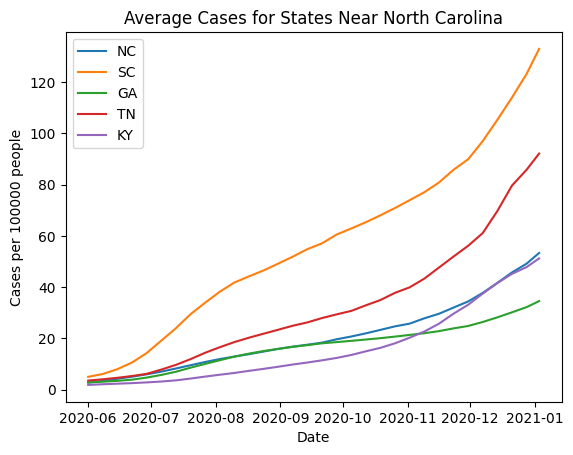

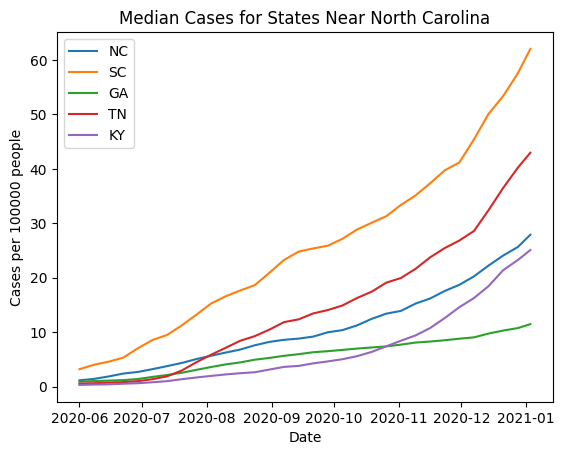

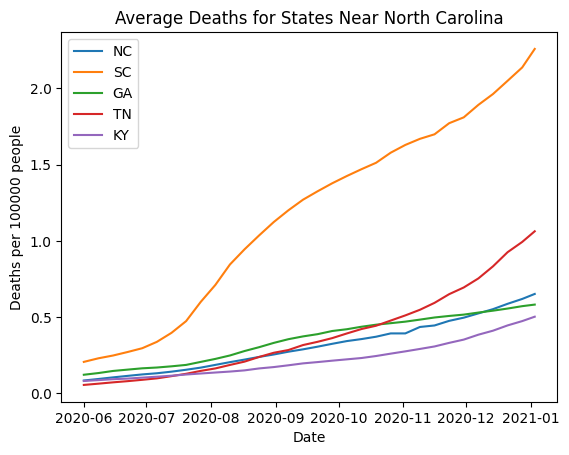

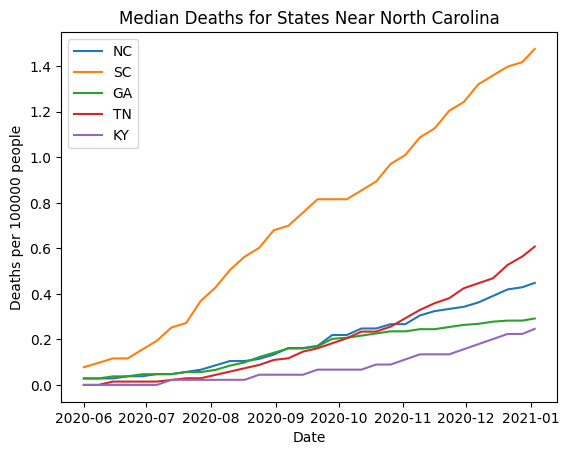

In [203]:
states = ['NC', 'SC', 'GA', 'TN', 'KY']

# Define X and Y variable data
for state in states:
    plt.plot(state_mean(state, covid_cases, 100000).T, label = state)
plt.xlabel("Date")  # add X-axis label
plt.ylabel("Cases per 100000 people")  # add Y-axis label
plt.title("Average Cases for States Near North Carolina")  # add title
plt.legend()
plt.show()

for state in states:
    plt.plot(state_median(state, covid_cases, 100000).T, label = state)
plt.xlabel("Date")  # add X-axis label
plt.ylabel("Cases per 100000 people")  # add Y-axis label
plt.title("Median Cases for States Near North Carolina")  # add title
plt.legend()
plt.show()

for state in states:
    plt.plot(state_mean(state, covid_deaths, 100000).T, label = state)
plt.xlabel("Date")  # add X-axis label
plt.ylabel("Deaths per 100000 people")  # add Y-axis label
plt.title("Average Deaths for States Near North Carolina")  # add title
plt.legend()
plt.show()

for state in states:
    plt.plot(state_median(state, covid_deaths, 100000).T, label = state)
plt.xlabel("Date")  # add X-axis label
plt.ylabel("Deaths per 100000 people")  # add Y-axis label
plt.title("Median Deaths for States Near North Carolina")  # add title
plt.legend()
plt.show()

# Why are the trends the way they are

Considering that all of the data collected is for states in geographically similar locations, the data here is interesting.  Kentucky performed the best in all of our studies while South Carolina consistently scored the worst especially when accounting for median cases and deaths.  The disparity between cases and deaths across states likely has to do with two things: availibility of healthcare, and contact management.  South Carolina had the worst contact management of all the states, while also having some of the least available healthcare. All values peak at the end of the data, and are comparable in shape to the United States data.  Considering that we sampled from the beginning of the pandemic, this makes sense.

# Finding the counties with the highest cases.

We will be using Texas for this.  Grabbing the data should be easy as I have already created a function for it.  The only code I need to write is for a program that pulls the top 5 most infected counties in Texas.

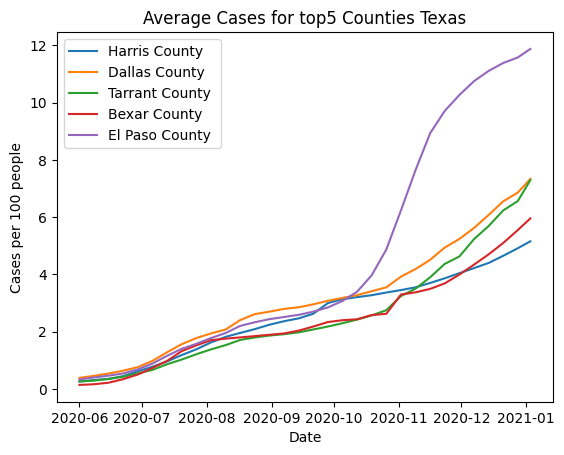

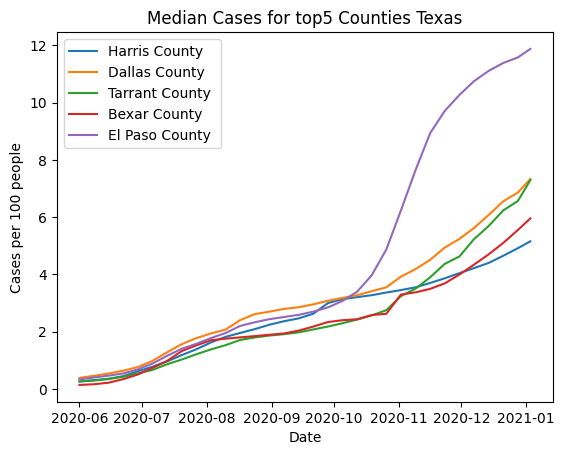

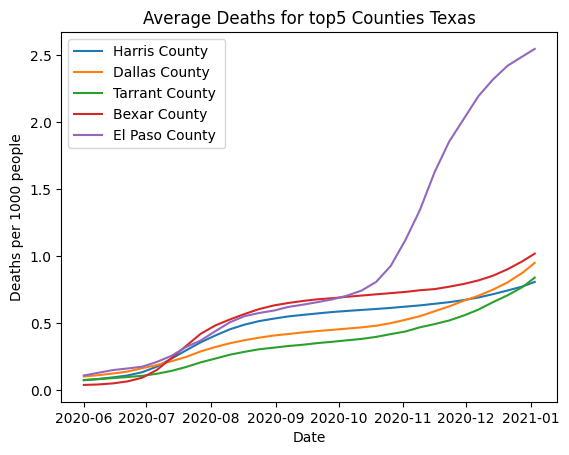

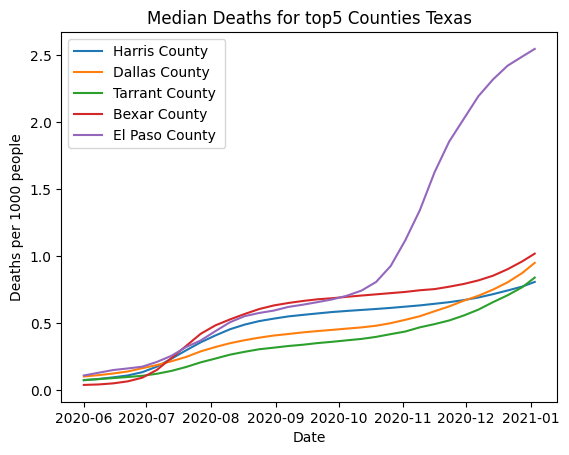

In [206]:
# Narrow our search down to texas
texas_data_c = covid_cases[covid_cases['State'] == 'TX']

#Separate our dataframe
texas_metaless = texas_data_c.drop(columns=['County Name', 'StateFIPS', 'countyFIPS', 'State'])

texas_data_c.insert(0, 'total cases', texas_metaless.T.agg(['max']).T)

#sort our info
max_data = texas_data_c.sort_values(by=['total cases'], ascending=False)

top5 = max_data.head(5).reset_index(drop=True)

#extract the useful bits
top5_counties = []
for i in range(5):
    fips = top5.at[i, 'countyFIPS']
    top5_counties.append(fips)

# Make our graphs

for county in top5_counties:
    info = county_mean(county, covid_cases, 100).T
    plt.plot(info, label = info.T.index)
plt.xlabel("Date")  # add X-axis label
plt.ylabel("Cases per 100 people")  # add Y-axis label
plt.title("Average Cases for top5 Counties Texas")  # add title
plt.legend()
plt.show()

for county in top5_counties:
    info = county_median(county, covid_cases, 100).T
    plt.plot(info, label = info.T.index)
plt.xlabel("Date")  # add X-axis label
plt.ylabel("Cases per 100 people")  # add Y-axis label
plt.title("Median Cases for top5 Counties Texas")  # add title
plt.legend()
plt.show()

for county in top5_counties:
    info = county_mean(county, covid_deaths, 1000).T
    plt.plot(info, label = info.T.index)
plt.xlabel("Date")  # add X-axis label
plt.ylabel("Deaths per 1000 people")  # add Y-axis label
plt.title("Average Deaths for top5 Counties Texas")  # add title
plt.legend()
plt.show()

for county in top5_counties:
    info = county_median(county, covid_deaths, 1000).T
    plt.plot(info, label = info.T.index)
plt.xlabel("Date")  # add X-axis label
plt.ylabel("Deaths per 1000 people")  # add Y-axis label
plt.title("Median Deaths for top5 Counties Texas")  # add title
plt.legend()
plt.show()



# County Conclusions

Looking at the data it seams that El Paso suffered a major outbreak in the last two weeks of 2020  This makes sense as it is the holiday season, and El Paso is a major hub for activity in Texas.  Looking back at my graph for Texas, it is clear that the increase in cases that they recieved towards the end of the year was largely carried by El Paso.  The fact that the other counties make it onto the list of highest cases likely just comes down to their large populations.  They are some of the most populous counties in Texas.